In [8]:
import pyfpgrowth
import pandas as pd
import numpy as np
import json
import fp_growth_py3 as fpg
import matplotlib.pyplot as plt

## 1. 数据预处理
从文件中读取数据集，对related_same_month_brand属性进行关联规则挖掘。
数据预处理主要是丢弃丢失值

In [9]:
def prefunction(x) :
    x = json.loads(x)
    if not x :
        return np.nan
    else :
        return x

converts = {
    "visitor_home_cbgs":prefunction,
    "visitor_work_cbgs":prefunction,
    "related_same_day_brand":prefunction,
    "related_same_month_brand":prefunction,
    "top_brands":prefunction,
    "popularity_by_hour":prefunction,
    "popularity_by_day":prefunction
}
    
data = pd.read_csv("cbg_patterns.csv",converters = converts)

dataSet = list(data["related_same_month_brand"].dropna())

## 2.找出频繁项集
利用FP-Growth算法，构造FP-tree，从FP-tree中找到频繁项集。设置最小支持度为0.2

输出所有频繁项集，及其支持度。

In [10]:
frequent_itemsets = fpg.find_frequent_itemsets(dataSet, minimum_support=0.2*len(dataSet), include_support=True)
print(type(frequent_itemsets))   # print type

result = []
for itemset, support in frequent_itemsets:    # 将generator结果存入list
    result.append((itemset, support/len(dataSet)))

    
result_patterns = [i[0] for i in result]
result_support = [i[1] for i in result]
patterns_df = pd.DataFrame({"fluent_patterns":result_patterns,"support":result_support})
patterns_df
patterns = {}
for i in result :
    patterns[tuple(sorted(i[0]))] = i[1]
result

<class 'generator'>


[(['mcdonalds'], 0.9480418090304567),
 (['walmart'], 0.7547439288732135),
 (['mcdonalds', 'walmart'], 0.7407142069877659),
 (['SUBWAY'], 0.4816304787097248),
 (['mcdonalds', 'SUBWAY'], 0.47428267019361475),
 (['walmart', 'SUBWAY'], 0.3606809581542305),
 (['mcdonalds', 'walmart', 'SUBWAY'], 0.35842609941584924),
 (['Shell Oil'], 0.3581138175539145),
 (['mcdonalds', 'Shell Oil'], 0.34609096586942945),
 (['walmart', 'Shell Oil'], 0.30347367647599105),
 (['mcdonalds', 'walmart', 'Shell Oil'], 0.2984587971637459),
 (['Dollar General'], 0.2802454168044381),
 (['mcdonalds', 'Dollar General'], 0.2741513281163893),
 (['walmart', 'Dollar General'], 0.27233733788897463),
 (['mcdonalds', 'walmart', 'Dollar General'], 0.2677174032844704),
 (['Chick-fil-A'], 0.21607149417686175),
 (['mcdonalds', 'Chick-fil-A'], 0.21132756530364818),
 (['walmart', 'Chick-fil-A'], 0.20571567654946912),
 (['mcdonalds', 'walmart', 'Chick-fil-A'], 0.20256530364818692),
 (['Chevron'], 0.21529078952202504),
 (['mcdonalds',

## 3.导出关联规则
从FP-tree和频繁项集中导出关联规则，并计算关联规则的置信度。

In [11]:
rules = pyfpgrowth.generate_association_rules(patterns, 0.7)
# rules_copy = rules;
# rules_a = list(rules.keys())
# confidence = [i[1] for i in list(rules.values())]
# rules_b = [i[0] for i in list(rules.values())]
# rules = {"rules_a":rules_a,"rules_b":list(rules_b),"confidence":confidence}
# rules = pd.DataFrame(rules)
rules
rules_a = [i for i in rules.keys()]
rules_b = [i[0] for i in rules.values()]
confidence = [i[1] for i in rules.values()]
rules_df = pd.DataFrame({"rules_a":rules_a,"rules_b":rules_b,"confidence":confidence})
rules_df

,rules_a,rules_b,confidence
0,"(mcdonalds,)","(walmart,)",0.781310
1,"(walmart,)","(mcdonalds,)",0.981411
2,"(SUBWAY,)","(mcdonalds, walmart)",0.744193
3,"(SUBWAY, mcdonalds)","(walmart,)",0.755723
4,"(SUBWAY, walmart)","(mcdonalds,)",0.993748
5,"(Shell Oil,)","(mcdonalds, walmart)",0.833419
6,"(Shell Oil, mcdonalds)","(walmart,)",0.862371
7,"(Shell Oil, walmart)","(mcdonalds,)",0.983475
8,"(Dollar General,)","(mcdonalds, walmart)",0.955296
9,"(Dollar General, mcdonalds)","(walmart,)",0.976531


## 4.对关联规则进行评价
使用Lift和全置信度指标进行评价。

In [12]:
lift= []
fsupport = []

# 计算Lift
for index,row in rules_df.iterrows():
    temp = patterns[tuple(sorted(list(row["rules_a"]+row["rules_b"])))] / patterns[row["rules_a"]] / patterns[row["rules_b"]] 
    lift.append(temp)
rules_df["lift"] = lift

# 计算kulc
for index,row in rules_df.iterrows():
    temp = patterns[tuple(sorted(list(row["rules_a"]+row["rules_b"])))] / patterns[row["rules_b"]] 
    fsupport.append( (row["confidence"]+temp)/2 )
rules_df["kulc"] = fsupport
rules_df

,rules_a,rules_b,confidence,lift,kulc
0,"(mcdonalds,)","(walmart,)",0.781310,1.035198,0.881360
1,"(walmart,)","(mcdonalds,)",0.981411,1.035198,0.881360
2,"(SUBWAY,)","(mcdonalds, walmart)",0.744193,1.004697,0.614043
3,"(SUBWAY, mcdonalds)","(walmart,)",0.755723,1.001297,0.615310
4,"(SUBWAY, walmart)","(mcdonalds,)",0.993748,1.048212,0.685909
5,"(Shell Oil,)","(mcdonalds, walmart)",0.833419,1.125156,0.618176
6,"(Shell Oil, mcdonalds)","(walmart,)",0.862371,1.142601,0.628907
7,"(Shell Oil, walmart)","(mcdonalds,)",0.983475,1.037375,0.649146
8,"(Dollar General,)","(mcdonalds, walmart)",0.955296,1.289696,0.658364
9,"(Dollar General, mcdonalds)","(walmart,)",0.976531,1.293858,0.665622


## 5.可视化展示挖掘结果 

<BarContainer object of 35 artists>

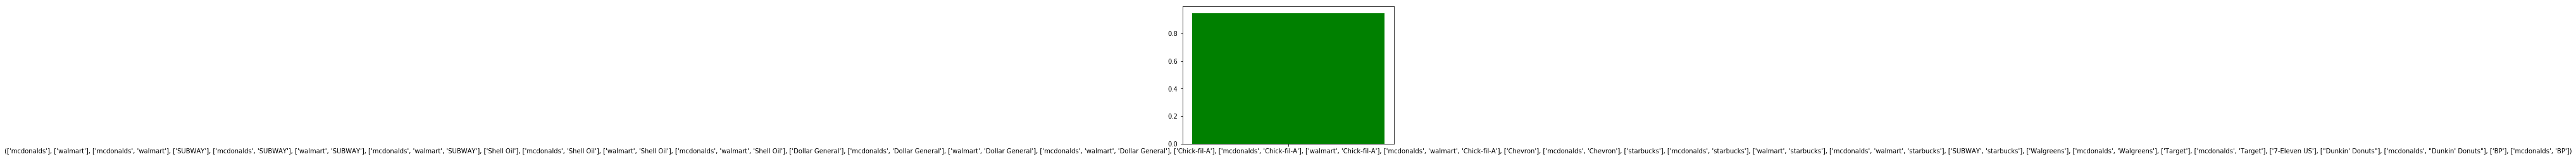

In [26]:
plt.bar(str(tuple(patterns_df["fluent_patterns"])),patterns_df["support"], label="two", color='g')